<a href="https://colab.research.google.com/github/kocurvik/mdrp/blob/main/demo/reposed_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RePosed Demo

This is a demo for the paper "RePoseD: Efficient Relative Pose Estimation With Known Depth Information" ICCV 2025 (oral) paper. DOI: TBA. Pre-print available on Arxiv: [2501.07742](https://arxiv.org/abs/2501.07742).

Code available in our [repo](https://github.com/kocurvik/mdrp). For more visual results see our [Project Page](https://kocurvik.github.io/reposed/).

The demo shows how to use the proposed solvers with MoGe and LightGlue to obtain the relative pose of two cameras and even merge the two MDE point clouds.

## Installing MoGe and LightGlue

First we install MoGe and Lightglue using their official repositories.

In [1]:
# Install MoGe for depth estimation
!pip install git+https://github.com/microsoft/MoGe.git
# Install LightGlue matching
!pip install git+https://github.com/cvg/LightGlue.git

  Cloning https://github.com/microsoft/MoGe.git to /tmp/pip-req-build-xbeobxaz
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/MoGe.git /tmp/pip-req-build-xbeobxaz
  Resolved https://github.com/microsoft/MoGe.git to commit 0286b495230a074aadf1c76cc5c679e943e5d1c6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/EasternJournalist/utils3d.git (to revision c5daf6f6c244d251f252102d09e9b7bcef791a38) to /tmp/pip-install-m3mjb3g7/utils3d_e9f936d932f94493a3549557d79a7422
  Running command git clone --filter=blob:none --quiet https://github.com/EasternJournalist/utils3d.git /tmp/pip-install-m3mjb3g7/utils3d_e9f936d932f94493a3549557d79a7422
  Running command git rev-parse -q --verify 'sha^c5daf6f6c244d251f252102d09e9b7bcef791a38'
  Running command git fetch -q https://github.com/EasternJournalist/utils3d.git c5daf6f6c244d251f252102d09e9b7bcef791a3

### Installing PoseLib with Solvers

Next we install PoseLib. To use this demo you can use the precompiled wheel. However, if you use a different python config (OS/python version) you may need to compile the C++ code yourself using (this will take few minutes).

In [2]:
# PR version, probably wont work now
!pip install https://github.com/kocurvik/mdrp/raw/refs/heads/main/demo/poselib-2.0.5-cp312-cp312-linux_x86_64.whl

### If you need to compile PoseLib in Colab yourself then use this:
#!git clone https://github.com/kocurvik/PoseLib
#%cd PoseLib
#!git checkout pr-mdrp
#!pip install pybind11_stubs
#!apt-get install libeigen3-dev
#!python setup.py install

### Outside of Google Colab you can try installing with:
#!pip install git+https://github.com/kocurvik/PoseLib@pr-mdrp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.9 MB/s eta 0:00:00


## Depth Estimation and Matching

We first process two images with MoGe and SuperPoint+LightGlue. We start by loading the models.

In [3]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt

# from moge.model.v1 import MoGeModel
from moge.model.v2 import MoGeModel

from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, rbd

import poselib

mde_model = MoGeModel.from_pretrained("Ruicheng/moge-2-vitl-normal").cuda()
extractor = SuperPoint(max_num_keypoints=2048).eval().cuda()
matcher = LightGlue(features='superpoint').eval().cuda()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.pt:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 101MB/s]


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth


100%|██████████| 45.3M/45.3M [00:00<00:00, 121MB/s]


Next we load the images. You can use the provided example images. You can load your own images here.

In [30]:
!wget https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/building_1.jpg
!wget https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/building_2.jpg
cv_image1 = cv2.cvtColor(cv2.imread("building_1.jpg"), cv2.COLOR_BGR2RGB)
cv_image2 = cv2.cvtColor(cv2.imread("building_2.jpg"), cv2.COLOR_BGR2RGB)

# These images demonstrate why estimateting the scale of MDEs is important.
# !wget https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/toy_car_1.jpg
# !wget https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/toy_car_2.jpg
# cv_image1 = cv2.cvtColor(cv2.imread("toy_car_1.jpg"), cv2.COLOR_BGR2RGB)
# cv_image2 = cv2.cvtColor(cv2.imread("toy_car_2.jpg"), cv2.COLOR_BGR2RGB)

# !wget https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/still_1.jpg
# !wget https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/still_2.jpg
# cv_image1 = cv2.cvtColor(cv2.imread("still_1.jpg"), cv2.COLOR_BGR2RGB)
# cv_image2 = cv2.cvtColor(cv2.imread("still_2.jpg"), cv2.COLOR_BGR2RGB)

--2025-10-11 11:43:42--  https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/building_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82586 (81K) [image/jpeg]
Saving to: ‘building_1.jpg.1’

building_1.jpg.1    100%[===================>]  80.65K  --.-KB/s    in 0.008s  

2025-10-11 11:43:43 (9.90 MB/s) - ‘building_1.jpg.1’ saved [82586/82586]

--2025-10-11 11:43:43--  https://raw.githubusercontent.com/kocurvik/mdrp/refs/heads/main/demo/images/building_2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

Then we run inference using the networks.

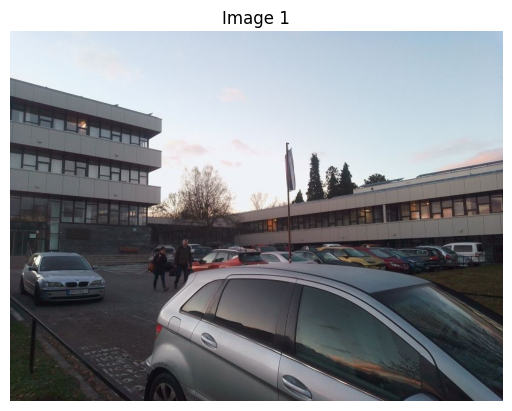

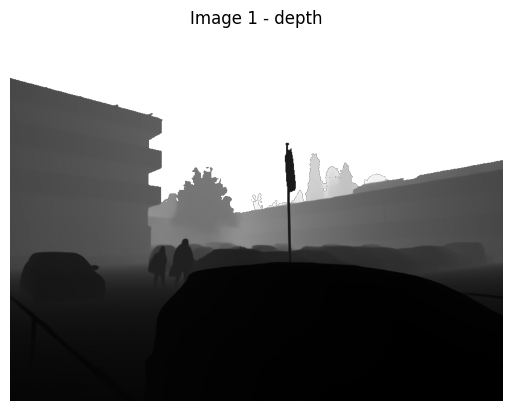

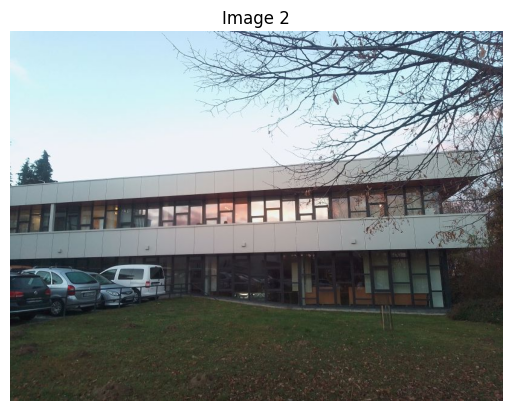

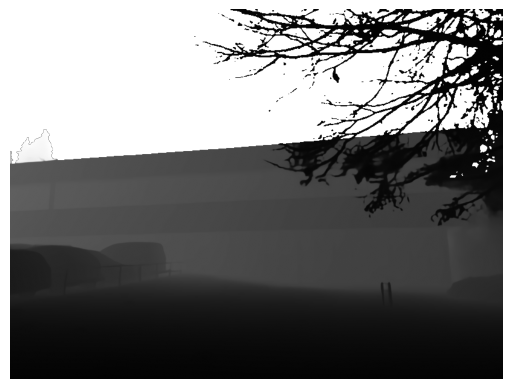

In [31]:
# convert images to torch tensor
image1 = torch.tensor(cv_image1 / 255, dtype=torch.float32, device='cuda').permute(2, 0, 1)
image2 = torch.tensor(cv_image2 / 255, dtype=torch.float32, device='cuda').permute(2, 0, 1)

# Infer Moge
mde_out1 = mde_model.infer(image1)
mde_out2 = mde_model.infer(image2)



plt.title("Image 1")
plt.imshow(cv_image1)
plt.axis('off')
plt.show()

plt.title("Image 1 - depth")
plt.imshow(mde_out1['depth'].detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

plt.title("Image 2")
plt.imshow(cv_image2)
plt.axis('off')
plt.show()

plt.imshow(mde_out2['depth'].detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Extract SuperPoint features
feats1 = extractor.extract(image1)
feats2 = extractor.extract(image2)

# Match the features using LightGlue
matches01 = matcher({'image0': feats1, 'image1': feats2})
feats1, feats2, matches01 = [rbd(x) for x in [feats1, feats2, matches01]]

We set up a function to visualize the pointcloud.

In [32]:
from typing import Optional
import plotly.graph_objects as go

# code taken from: https://github.com/cvg/Hierarchical-Localization/blob/master/hloc/utils/viz_3d.py

def init_figure(height: int = 800) -> go.Figure:
    """Initialize a 3D figure."""
    fig = go.Figure()
    axes = dict(
        visible=False,
        showbackground=False,
        showgrid=False,
        showline=False,
        showticklabels=True,
        autorange=True,
    )
    fig.update_layout(
        template="plotly_dark",
        height=height,
        scene_camera=dict(
            eye=dict(x=0., y=-.1, z=-2),
            up=dict(x=0, y=-1., z=0),
            projection=dict(type="orthographic")),
        scene=dict(
            xaxis=axes,
            yaxis=axes,
            zaxis=axes,
            aspectmode='data',
            dragmode='orbit',
        ),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.1
        ),
    )
    return fig


def plot_points(
        fig: go.Figure,
        pts: np.ndarray,
        color: str = 'rgba(255, 0, 0, 1)',
        ps: int = 2,
        colorscale: Optional[str] = None,
        name: Optional[str] = None):
    """Plot a set of 3D points."""
    x, y, z = pts.T
    tr = go.Scatter3d(
        x=x, y=y, z=z, mode='markers', name=name, legendgroup=name,
        marker=dict(
            size=ps, color=color, line_width=0.0, colorscale=colorscale))
    fig.add_trace(tr)


def plot_interactive_pointcloud(xyz, rgb, subsampling_rate=0.05):
  # plots a plotly pointcloud
  # params:
  # xyz - n x 3 - array with 3D coordinates of points
  # rgb - n x 3 - array with RGB triplets in 0-255
  n = xyz.shape[0]

  l = np.random.rand(n) <= subsampling_rate
  fig = init_figure()
  plot_points(fig, xyz[l], color=rgb[l])
  fig.show()

# alternative viewer
# !pip install open3d
# import open3d as o3d
# def plot_interactive_pointcloud(xyz, rgb):
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(xyz)
#     pcd.colors = o3d.utility.Vector3dVector(rgb)  # Colors should be in [0,1]

#     # Visualize using Plotly
#     o3d.visualization.draw_plotly([pcd], point_sample_factor=0.05, window_name="Point Cloud Viewer", width=800, height=600)

Once depth and the intrinsics are available we can calculate the pointcloud.

In [33]:
def get_pointcloud(K_inv, depth_map, color_map):
  H, W = depth_map.shape
  u = np.arange(W)
  v = np.arange(H)
  uu, vv = np.meshgrid(u, v)

  z = depth_map.flatten()
  uu = uu.flatten()
  vv = vv.flatten()
  proj = np.vstack([uu, vv, np.ones_like(uu)])

  flattened_colors = color_map.reshape([-1, 3])

  return z[:, np.newaxis] * (K_inv @ proj).T, flattened_colors


### Running RePoseD

Finally, we can run the poselib implementation of RePoseD.

In [34]:
# convert the matches to numpy
matches = matches01['matches']
points1 = feats1['keypoints'][matches[..., 0]].cpu().numpy()
points2 = feats2['keypoints'][matches[..., 1]].cpu().numpy()

# extract depths for each keypoint
depth_map1 = mde_out1["depth"].cpu().numpy()
depth_map2 = mde_out2["depth"].cpu().numpy()
depths1 = depth_map1[points1[:, 1].astype(int), points1[:, 0].astype(int)]
depths2 = depth_map2[points2[:, 1].astype(int), points2[:, 0].astype(int)]

l = ~np.logical_and(np.isinf(depths1), np.isinf(depths2))

pp1 = np.array([cv_image1.shape[1] / 2, cv_image1.shape[0] / 2])
pp2 = np.array([cv_image2.shape[1] / 2, cv_image2.shape[0] / 2])

ransac_dict = {'max_epipolar_error': 2.0, 'max_reproj_error': 16.0}
# set this to true if you also want to estimate shit (calib case only)
ransac_dict['estimate_shift'] = False

# use this loss for better estimation
bundle_dict = {'loss_type': 'TRUNCATED_CAUCHY'}

h1, w1 = cv_image1.shape[:2]
h2, w2 = cv_image2.shape[:2]

instrinsics1 = mde_out1['intrinsics'].cpu().numpy()
instrinsics2 = mde_out2['intrinsics'].cpu().numpy()

# MoGe also provides estimated focal length
f1, px1, py1 = w1*instrinsics1[0, 0], w1*instrinsics1[0, 2], h1*instrinsics1[1, 2]
f2, px2, py2 = w2*instrinsics2[0, 0], w2*instrinsics2[0, 2], h2*instrinsics2[1, 2]

## Since focals are known we can use the calibrated solver.
camera1 = {'model': 'SIMPLE_PINHOLE', 'width': -1, 'height': -1, 'params': [f1, px1, py1]}
camera2 = {'model': 'SIMPLE_PINHOLE', 'width': -1, 'height': -1, 'params': [f2, px2, py2]}
pose, info = poselib.estimate_monodepth_pose(points1[l], points2[l], depths1[l], depths2[l], camera1, camera2, ransac_dict, bundle_dict)

## In case focals are not known or you don't trust them you can use this code to
## estimate them along with the pose with when the images are taken by a single
## camera.
# image_pair, info = poselib.estimate_monodepth_shared_focal_pose(points1[l] - pp1, points2[l] - pp2, depths1[l], depths2[l], ransac_dict, bundle_dict)
# f1 = image_pair.camera1.focal()
# f2 = image_pair.camera2.focal()
# pose = image_pair.pose

## If the images are captured by different cameras you can use this version.
# image_pair, info = poselib.estimate_monodepth_varying_focal_pose(points1[l] - pp1, points2[l] - pp2, depths1[l], depths2[l], ransac_dict, bundle_dict)
# f1 = image_pair.camera1.focal()
# f2 = image_pair.camera2.focal()
# pose = image_pair.pose

print(info)

K1 = np.array([[f1, 0, px1], [0, f1, py1],[0, 0, 1]])
K2 = np.array([[f2, 0, px2], [0, f2, py2],[0, 0, 1]])
K1_inv = np.linalg.inv(K1)
K2_inv = np.linalg.inv(K2)

xyz1, rgb1 = get_pointcloud(K1_inv, depth_map1, cv_image1)
xyz2, rgb2 = get_pointcloud(K2_inv, depth_map2, cv_image2)


# xyz1_in2 = (image_pair.pose.R @ xyz1.T).T + image_pair.pose.t
xyz1_in2 = (1/pose.scale) * ((pose.R @ xyz1.T).T + pose.t)

print("Estimated scale: ", pose.scale)

xyz_merged = np.vstack([xyz1_in2, xyz2])
rgb_merged = np.vstack([rgb1, rgb2])

plot_interactive_pointcloud(xyz_merged, rgb_merged)

{'refinements': 6, 'iterations': 1001, 'num_inliers': 110, 'inlier_ratio': 0.738255033557047, 'model_score': 0.0006121910140635083, 'inliers': [True, False, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, False, False, False, False, True, False, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, False, True, True, True, False, True, False, False, False, False, False

/tmp/ipython-input-2841307706.py:14: RuntimeWarning:

invalid value encountered in multiply

/tmp/ipython-input-1492519922.py:65: RuntimeWarning:

invalid value encountered in matmul

